In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

from env import user, host, password
def get_db_url(db):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [2]:
query = '''
SELECT * FROM customers
JOIN internet_service_types USING (internet_service_type_id)
'''

df = pd.read_sql(query, get_db_url('telco_churn'))
# select just the columns we want
df = df[['tenure', 'total_charges', 'monthly_charges', 'internet_service_type', 'phone_service']]
# cleanup total_charges
df = df[df.total_charges != ' ']
df.total_charges = df.total_charges.astype(float)

In [3]:
df

,tenure,total_charges,monthly_charges,internet_service_type,phone_service
0,9,593.30,65.60,DSL,Yes
1,9,542.40,59.90,DSL,Yes
2,9,571.45,69.40,DSL,Yes
3,7,340.35,48.20,DSL,Yes
4,65,5957.90,90.45,DSL,Yes
...,...,...,...,...,...
7038,6,129.55,19.70,None,Yes
7039,67,1372.90,19.25,None,Yes
7040,46,856.50,19.75,None,Yes
7041,1,18.90,18.90,None,Yes


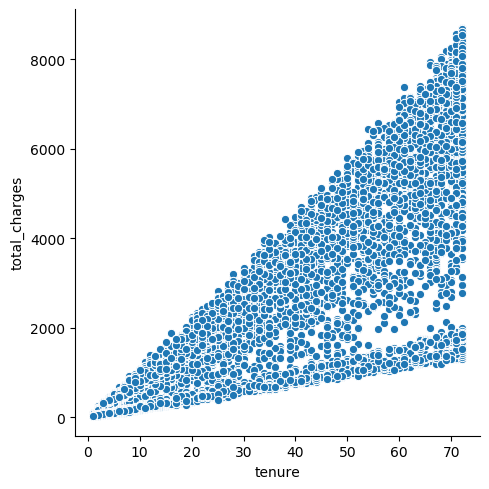

In [21]:
sns.relplot(data=df, y='total_charges', x='tenure')

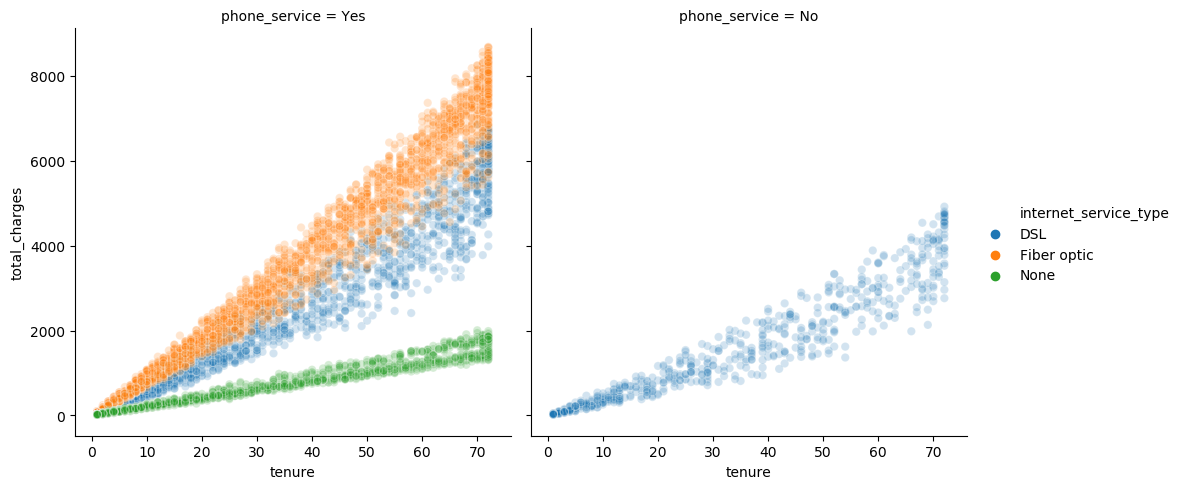

In [15]:
sns.relplot(data=df, y='total_charges', x='tenure', alpha=.2, hue='internet_service_type', col='phone_service')

In [16]:
stats.pearsonr(df.tenure, df.total_charges)

(0.8258804609332021, 0.0)

In [20]:
any_internet = df[df.internet_service_type != 'None']

stats.pearsonr(any_internet.tenure, any_internet.total_charges)

(0.9319346187418098, 0.0)

In [22]:
no_internet = df[df.internet_service_type == 'None']

stats.pearsonr(no_internet.tenure, no_internet.total_charges)

(0.9814648859044287, 0.0)

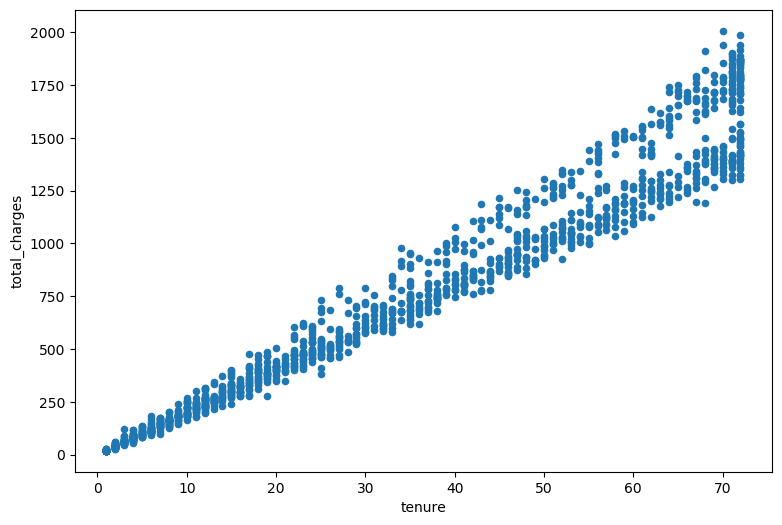

In [19]:
no_internet.plot.scatter(y='total_charges', x='tenure')

Is there a relationship between how long an employee has been with the company and their salary?

In [23]:
query = '''
SELECT
    DATEDIFF(end_date, start_date) / 365.25 AS tenure,
    salary
FROM (
    SELECT
        e.emp_no,
        e.hire_date AS start_date,
        MAX(s.salary) AS salary,
        IF(
            de.to_date = '9999-01-01',
            (SELECT MAX(hire_date) FROM employees),
            de.to_date
        ) as end_date
    FROM employees e
    JOIN dept_emp de USING (emp_no)
    JOIN salaries s USING (emp_no)
    GROUP BY e.emp_no, start_date, end_date
) a
'''

employees = pd.read_sql(query, get_db_url('employees'))

In [6]:
employees.head()

,tenure,salary
0,13.5907,88958
1,14.1848,72527
2,13.4182,43699
3,13.1581,74057
4,10.3765,94692


In [24]:
stats.pearsonr(employees.tenure, employees.salary)

(0.30984532042633595, 0.0)

Is there a relationship between how long an employee has been with the company and the number of titles they have had?

In [26]:
query = '''
SELECT
    DATEDIFF(end_date, start_date) / 365.25 AS tenure,
    n_titles
FROM (
    SELECT
        e.emp_no,
        e.hire_date AS start_date,
        COUNT(*) AS n_titles,
        IF(
            de.to_date = '9999-01-01',
            (SELECT MAX(hire_date) FROM employees),
            de.to_date
        ) as end_date
    FROM employees e
    JOIN dept_emp de USING (emp_no)
    JOIN titles t USING (emp_no)
    GROUP BY e.emp_no, start_date, end_date
) a
'''

employees = pd.read_sql(query, get_db_url('employees'))

In [8]:
employees.head()

,tenure,n_titles
0,13.6000,1
1,14.1945,1
2,13.4274,1
3,13.1671,2
4,10.3836,2


In [31]:
employees.groupby('n_titles').tenure.mean()

n_titles
1     8.064467
2    10.519794
3    12.011805
4    11.718000
Name: tenure, dtype: float64

In [32]:
stats.ttest_1samp(employees[employees.n_titles == 1].tenure, employees.mean())

Ttest_1sampResult(statistic=tenure     -117.564095
n_titles    666.144531
dtype: float64, pvalue=array([0., 0.]))

In [37]:
# tenure v n_titles
employees.groupby('n_titles').tenure.agg(['min', 'mean', 'max', 'count'])

,min,mean,max,count
n_titles,,,,
1,0.0000,8.064467,17.4702,176629
2,0.0000,10.519794,17.4894,151610
3,0.0055,12.011805,17.0979,3346
4,7.4196,11.718000,14.3737,4


Text(0, 0.5, 'Count')

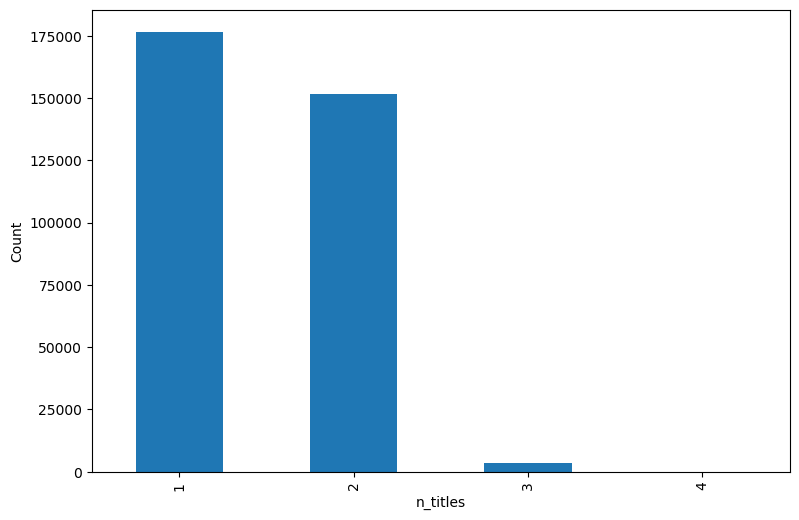

In [35]:
employees.groupby('n_titles').tenure.count().plot.bar()
plt.ylabel('Count')

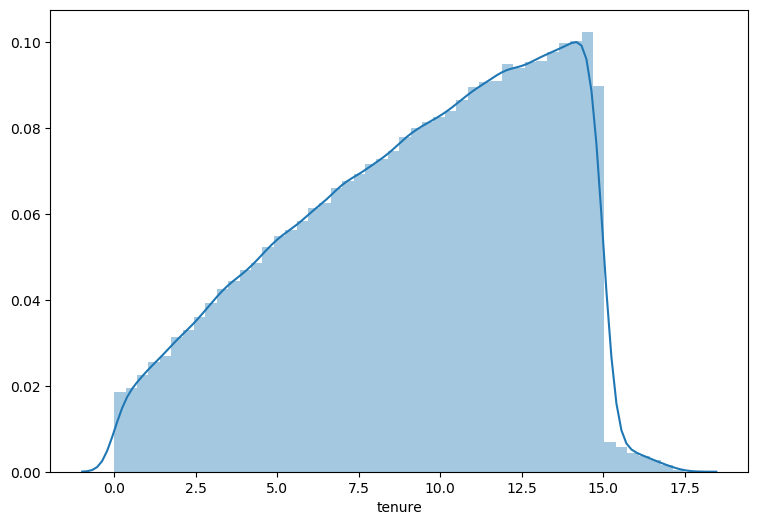

In [33]:
sns.distplot(employees.tenure)

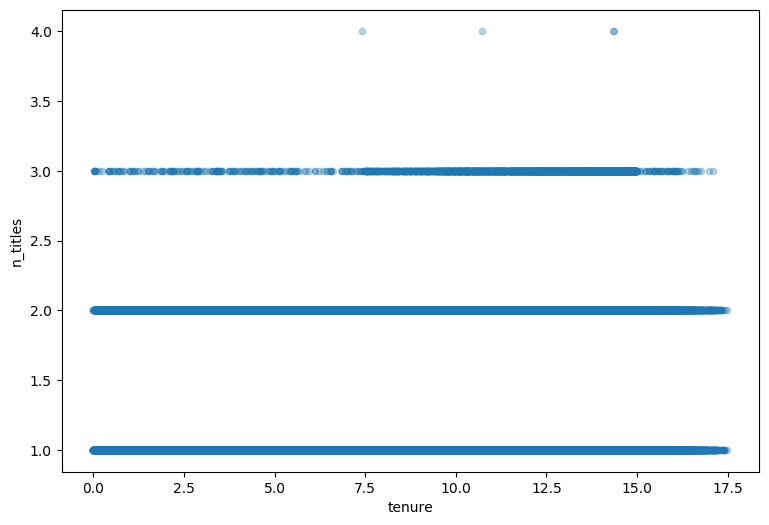

In [27]:
employees.plot.scatter(y='n_titles', x='tenure', alpha=.3)

Is an employee's gender independent of whether an employee works in sales or marketing? (only look at current employees)

In [38]:
query = '''
SELECT
    e.gender,
    d.dept_name AS department
FROM employees e
JOIN dept_emp de USING (emp_no)
JOIN departments d USING (dept_no)
WHERE de.to_date > NOW()
'''

employees = pd.read_sql(query, get_db_url('employees'))

employees = employees[employees.department.isin(['Sales', 'Marketing'])]

In [39]:
employees.head()

,gender,department
104290,F,Marketing
104291,M,Marketing
104292,F,Marketing
104293,F,Marketing
104294,F,Marketing


In [44]:
employees['is_female'] = employees.gender == 'F'
employees.head()

,gender,department,is_female
104290,F,Marketing,True
104291,M,Marketing,False
104292,F,Marketing,True
104293,F,Marketing,True
104294,F,Marketing,True


In [46]:
employees.is_female.mean()

0.3970652608339836

In [47]:
employees.groupby('department').is_female.mean()

department
Marketing    0.395095
Sales        0.397841
Name: is_female, dtype: float64

In [43]:
gender = employees.gender
department = employees.department

ctab = pd.crosstab(gender, department)

stats.chi2_contingency(ctab)

(0.3240332004060638,
 0.5691938610810126,
 1,
 array([[ 5893.2426013, 14969.7573987],
        [ 8948.7573987, 22731.2426013]]))

In [41]:
stats.chi2_contingency(pd.crosstab(employees.gender, employees.department))

(0.3240332004060638,
 0.5691938610810126,
 1,
 array([[ 5893.2426013, 14969.7573987],
        [ 8948.7573987, 22731.2426013]]))

![](https://imgs.xkcd.com/comics/correlation.png)

Is an employee's gender independent of whether or not they are or have been a manager?

In [48]:
query = '''
SELECT
    e.emp_no IN (SELECT emp_no FROM dept_manager) AS is_manager,
    e.gender
FROM employees e
'''

employees = pd.read_sql(query, get_db_url('employees'))

In [12]:
employees.head()

,is_manager,gender
0,0,M
1,0,F
2,0,M
3,0,M
4,0,M


In [49]:
employees.is_manager.value_counts()

0    300000
1        24
Name: is_manager, dtype: int64

In [50]:
stats.chi2_contingency(pd.crosstab(employees.is_manager, employees.gender))

(1.4566857643547197,
 0.22745818732810363,
 1,
 array([[1.20041397e+05, 1.79958603e+05],
        [9.60331174e+00, 1.43966883e+01]]))

In [51]:
pd.crosstab(employees.is_manager, employees.gender)

gender,F,M
is_manager,,
0,120038,179962
1,13,11


## Bonus SQL Query

Impress your friends with this one!

```sql
SELECT
    COALESCE(dept_name, 'OVERALL AVERAGE') AS dept,
    AVG(is_female) AS p_female,
    COUNT(*) AS n
FROM (
    SELECT
        e.gender = 'F' AS is_female,
        d.dept_name
    FROM employees e
    JOIN dept_emp de USING (emp_no)
    JOIN departments d USING (dept_no)
) a
GROUP BY dept_name WITH ROLLUP;
```